# Setup

In [2]:
from pycocotools.coco import COCO
import os
from colorama import Fore, Style
import json
import numpy as np

In [55]:
use_skf_splits = False

# Dataset load

In [89]:
dataset_path = './dataset_archive/'
train_annotations_path = os.path.join(dataset_path, 'train/', '_annotations.coco.json')
valid_annotations_path = os.path.join(dataset_path, 'valid/', '_annotations.coco.json')

with open(train_annotations_path) as f1, open(valid_annotations_path) as f2:
    train_data_in = json.load(f1)
    valid_data_in = json.load(f2)

In [90]:
len(train_data_in['annotations'])

5009

In [92]:
len(valid_data_in['annotations'])

1648

# (Optional) Split the dataset using the multi-Stratified K-fold CSV files

The CSV files have been previously generated using the multilabel Stratified K-Fold (**mskf**) technique in order to balance classes distributions across dataset splits. If you wish to generate different versions of dataset splits (e.g. with different *k*, different algorithm, etc...), you can do that in the `stratified_kfold.ipynb` notebook. We have provided these splits to make them a baseline as they are used for our metrics. 

Each CSV file has the following columns:

- `IMADE_ID` - an integer representing the image ID from the original json annottaions file
- `IMAGE_PATH` - the corresponding image path
- `SPLIT` - either **train** or **valid**

In [67]:
import pandas as pd
import utils

if use_skf_splits:
    csv_files = ['mskf_0.csv', 'mskf_1.csv', 'mskf_2.csv', 'mskf_3.csv'] 
    
    for idx, csv_file in enumerate(csv_files):
        mskf = pd.read_csv(csv_file)
        utils.create_directories_and_copy_files('path/to/dest', data_in, mskf, idx)

# Visualise a dataset version

Now, let's choose one of the dataset versions and visualize it.

In [86]:
data_dir = dataset_path
splits = ['train', 'valid']

coco_objects = {}

for split in splits:
    annotations_file = os.path.join(str(data_dir), str(split), '_annotations.coco.json')
    coco_objects[split] = COCO(annotations_file)
    
    # get class categories in the current split
    categories = coco_objects[split].loadCats(coco_objects[split].getCatIds())
    category_names = [cat['name'] for cat in categories]
    print(f"{Fore.BLUE}Class categories in {split}: {category_names}{Style.RESET_ALL}")

    annotation_ids = {}

    # get annotations in the current split
    annotation_ids[split] = coco_objects[split].getAnnIds()
    annotations = coco_objects[split].loadAnns(annotation_ids[split])
    print(f"{Fore.BLUE}Number of annotations in {split}: {len(annotations)}{Style.RESET_ALL}")
    
    # get image IDs in the current split
    img_ids = coco_objects[split].getImgIds()
    images = coco_objects[split].loadImgs(img_ids)
    print(f"{Fore.BLUE}Number of images in {split}: {len(images)}{Style.RESET_ALL}")

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Class categories in train: ['central-ring', 'other', 'read-out-streak', 'smoke-ring', 'star-loop']
Number of annotations in train: 5009
Number of images in train: 791
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Class categories in valid: ['central-ring', 'other', 'read-out-streak', 'smoke-ring', 'star-loop']
Number of annotations in valid: 1648
Number of images in valid: 264


In [87]:
from tabulate import tabulate

table_data = []

for split in splits:
    annotations_file = os.path.join(data_dir, split, '_annotations.coco.json')
    coco = COCO(annotations_file)
    cat_ids = coco.getCatIds()
    categories = coco.loadCats(cat_ids)
    cat_names = [cat['name'] for cat in categories]
    cat_counts = [len(coco.getAnnIds(catIds=[cat_id])) for cat_id in cat_ids]
    total_count = sum(cat_counts)

    for cat_name, count in zip(cat_names, cat_counts):
        percentage = (count / total_count) * 100 if total_count > 0 else 0
        if percentage > 0:
            table_data.append({
                'Split': '#'+split.capitalize()+' (%)',
                'Category': cat_name,
                'Count': count,
                'Percentage': np.round(percentage, 3)
            })

df = pd.DataFrame(table_data)
pivot_count = df.pivot_table(index='Category', columns='Split', values='Count', fill_value=0)
pivot_percentage = df.pivot_table(index='Category', columns='Split', values='Percentage', fill_value=0.0)
combined_df = pivot_count.astype(str) + " (" + pivot_percentage.astype(str) + ")"

styled_df = combined_df.style.apply(utils.highlight_max_str, subset=['#Train (%)', '#Valid (%)'])\
                           .format({'#Train (%)': "{:}", '#Valid (%)': "{:}"})\
                           .set_properties(**{'text-align': 'center', 'font-size': '10pt'})\
                           .set_table_styles([{'selector': 'th', 'props': [('font-size', '12pt')]}])\
                           .set_caption("Annotation Counts and Percentages by Filter and Split")
styled_df

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


We can also see how many images per filter we have.

In [88]:
filter_count = {'U': 0, 'V': 0, 'B': 0, 'W': 0, 'S': 0, 'M': 0, 'L': 0}
filter_annots_count = filter_count.copy()


for split in splits:
    annotations_file = os.path.join(data_dir, split, '_annotations.coco.json')
        
    with open(annotations_file) as f:
        data_in = json.load(f)
    
    for img in data_in['images']:
        filter = img['file_name'][:13][-1] # The OM observations IDs are 13 characters long, the last of them representing the filter
        filter_count[filter] += 1
        image_annots = [annot for annot in data_in['annotations'] if annot['image_id'] == img['id']]
        for annot in image_annots:
            filter_annots_count[filter] += 1
    
    df_counts = pd.DataFrame(list(filter_count.items()), columns=['Observing Filter', 'Image Count'])
    df_annot_counts = pd.DataFrame(list(filter_annots_count.items()), columns=['Observing Filter', 'Annotation Count'])
    df_merged = pd.merge(df_counts, df_annot_counts, on='Observing Filter')
    
filters_df = df_merged.style.apply(utils.highlight_max, subset=['Image Count', 'Annotation Count'])\
                           .format({'Image Count': "{:,}", 'Annotation Count': "{:,}"})\
                           .set_properties(**{'text-align': 'center', 'font-size': '10pt'})\
                           .set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])\
                           .set_caption("Counts of Images and Annotations per Filter")
    
filters_df

## Mask heatmap

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


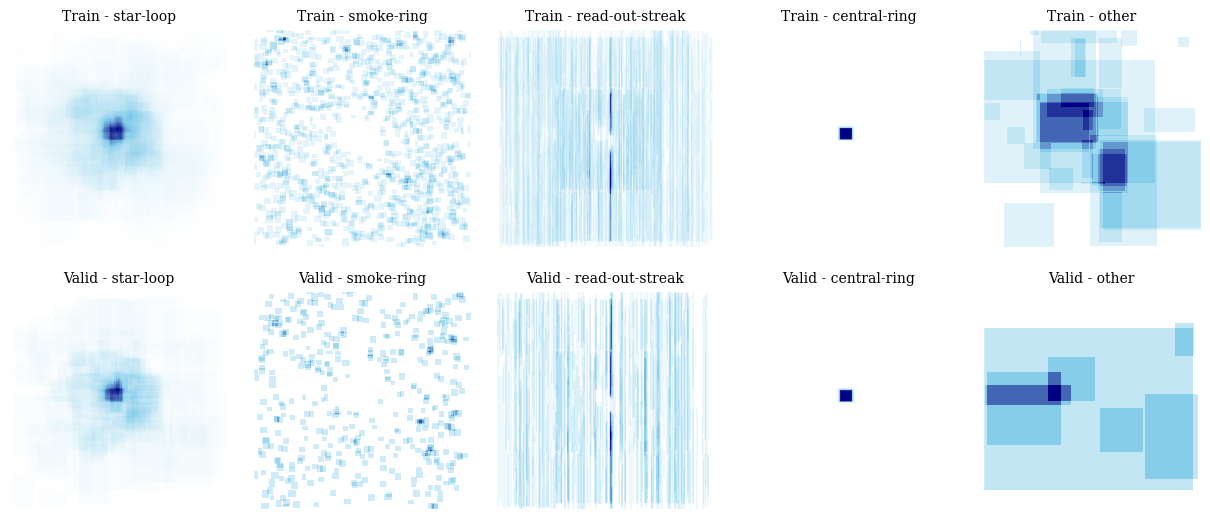

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import style
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

all_categories = set()
coco_objects = {}
for split in splits:
    annotations_file = os.path.join(str(data_dir), str(split), '_annotations.coco.json')
    coco = COCO(annotations_file)
    coco_objects[split] = coco
    categories = coco.loadCats(coco.getCatIds())
    all_categories.update([cat['name'] for cat in categories])

sorted_categories = ['star-loop', 'smoke-ring', 'read-out-streak', 'central-ring', 'other'] # sorted(list(all_categories))
img_width, img_height = 512, 512

style.use('ggplot')
fig, axes = plt.subplots(len(splits), len(sorted_categories), figsize=(3 * len(sorted_categories), 6), squeeze=False)

for i, cat_name in enumerate(sorted_categories):
    for j, split in enumerate(splits):
        coco = coco_objects[split]
        cat_id = coco.getCatIds(catNms=[cat_name])
        ann_ids = coco.getAnnIds(catIds=cat_id)
        annotations = coco.loadAnns(ann_ids)
        heatmap = np.zeros((img_height, img_width))

        for ann in annotations:
            bbox = ann['bbox']
            x, y, w, h = map(int, bbox)
            heatmap[y:y + h, x:x + w] += 1

        colors = ['white', 'skyblue', 'navy']
        cm = LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
        ax = axes[j, i]  # Change here: use two indices for axes
        im = ax.imshow(heatmap, cmap=cm, interpolation='nearest')
        ax.set_title(f'{split.capitalize()} - {cat_name}', fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

plt.tight_layout(pad=0.0)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.2, wspace=0.07)
plt.savefig('./plots/artefact_distributions.png')
plt.show()
plt.close()

## Galactic coordinates plotting

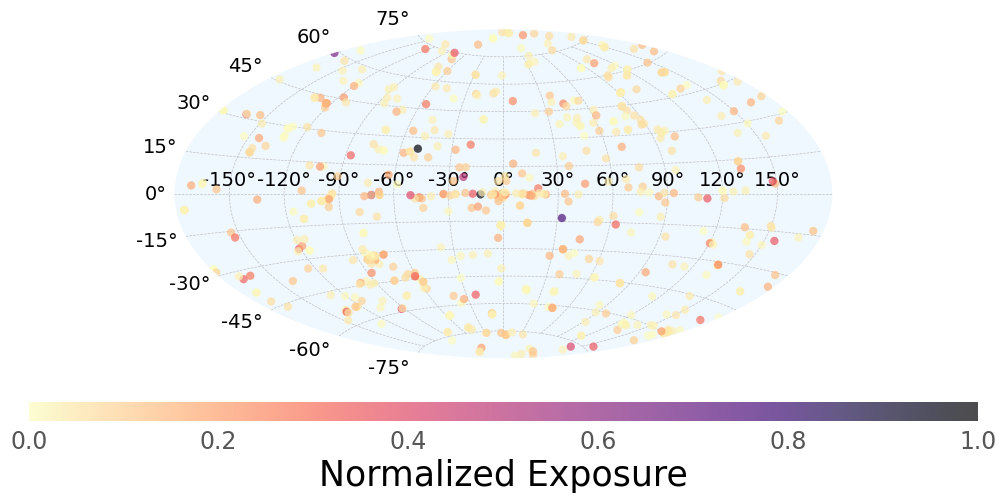

In [72]:
import json
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style

# import the filename that contains observations with coordinates and exposure times
all_obs_coords = './obs_info_1024_all.json'

with open(all_obs_coords, 'r') as file:
    coords_data = json.load(file)

ra = []
dec = []
exposures = []

for split in splits: 
    for image_file in os.listdir(data_dir + f'/{split}'):
        obs = image_file.split('.')[0].replace('_png', '.fits')
        if obs in coords_data:
            ra.append(coords_data[obs]['RA'])
            dec.append(coords_data[obs]['DEC'])
            exposures.append(coords_data[obs]['EXPOSURE'])

coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
galactic = coords.galactic

exposure_norm = (exposures - np.min(exposures)) / (np.max(exposures) - np.min(exposures))

plt.style.use(astropy_mpl_style)
plt.rcParams.update({'font.size': 16, 'font.family': 'sans-serif'})

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="aitoff")
sc = ax.scatter(galactic.l.wrap_at(180*u.deg).radian, galactic.b.wrap_at(180*u.deg).radian,
                c=exposure_norm, cmap='magma_r', alpha=0.7, edgecolor='none', zorder=1)

ax.grid(True, color='silver', linestyle='--', linewidth=0.5)

ax.tick_params(axis='x', labelsize=14, colors='black', zorder=2)
ax.tick_params(axis='y', labelsize=14, colors='black', zorder=2)

ax.set_facecolor('aliceblue')  # A soft white background color

cbar = plt.colorbar(sc, orientation='horizontal', pad=0.1, aspect=50)
cbar.set_label('Normalized Exposure', fontsize=25)
cbar.ax.tick_params(labelsize=17) 
cbar.outline.set_visible(False)  
cbar.ax.xaxis.set_tick_params(color='black')  

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=0.3)
# plt.savefig('dataset_galactic_distribution.png', dpi=300)  
plt.show()